#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**

using the airbnb dataset

version 0.92 2021-07-05

In [68]:
import pandas as pd
import numpy as np

from plotnine import *
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import warnings

warnings.filterwarnings("ignore")

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from skranger.ensemble import RangerForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
def plot_pred_true_scatter(true_price,predicted_price,title="asd"):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.scatter(true_price, predicted_price)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel("True price")
    plt.ylabel("Predicted price")
    plt.title(title)
    plt.show()
    
def corr_pred(array):
    return np.exp(array)*np.exp(residual_std)

## PART I
### Loading and preparing data 
----------------------------------------------

In [35]:
area = "bangkok"
data = pd.read_csv("../data/airbnb_" + area + "_workfile_all_am.csv")
data = data.loc[data.price.notna(), :]

In [36]:
data.isnull().sum().sum()

0

In [37]:
# Sample definition 
data = data.query('2 <= n_accommodates <= 6')

In [367]:
data.shape

(8162, 136)

In [38]:
data.price.describe(percentiles=[0.5,0.9,0.95,0.98])

count      8162.000000
mean       1752.934942
std        4889.231501
min         269.000000
50%        1097.500000
90%        2856.800000
95%        3956.550000
98%        7452.140000
max      254623.000000
Name: price, dtype: float64

In [39]:
data.describe().T.head(30)

,count,mean,std,min,25%,50%,75%,max
price,8162.0,1752.934942,4889.231501,269.00,730.00,1097.50,1700.00,254623.00
price_clean,8162.0,1752.934942,4889.231501,269.00,730.00,1097.50,1700.00,254623.00
n_bathrooms,8162.0,1.223291,0.507486,0.00,1.00,1.00,1.50,23.00
n_accommodates,8162.0,2.894511,1.142799,2.00,2.00,2.00,4.00,6.00
n_review_scores_rating,8162.0,4.667452,0.618247,0.00,4.69,4.80,4.89,5.00
n_number_of_reviews,8162.0,18.873683,40.229989,0.00,0.00,3.00,19.00,1116.00
n_reviews_per_month,8162.0,0.607166,0.794160,0.01,0.22,0.38,0.66,24.31
n_minimum_nights,8162.0,16.302867,43.728870,1.00,1.00,2.00,20.00,730.00
n_beds,8162.0,1.448542,0.794301,0.00,1.00,1.00,2.00,7.00
n_maximum_nights,8162.0,891.822838,1950.527949,1.00,365.00,1125.00,1125.00,100000.00


<AxesSubplot:>

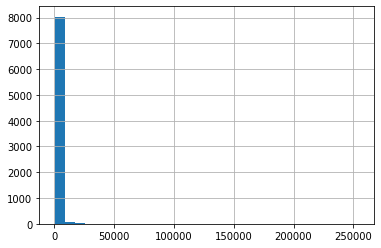

In [40]:
data.price.hist(bins=30)

<AxesSubplot:>

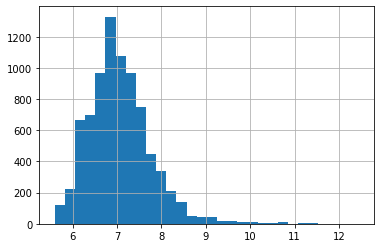

In [41]:
np.log(data.price).hist(bins=30)

In [42]:
data["lnprice"] = np.log(data.price)

In [43]:
data.f_property_type.value_counts()

Entire rental unit            4347
Entire condominium (condo)    3382
Entire serviced apartment      433
Name: f_property_type, dtype: int64

In [44]:
data.f_number_of_reviews.value_counts()

1    4650
0    2577
2     935
Name: f_number_of_reviews, dtype: int64

Create train and holdout samples 

In [45]:
data.f_neighbourhood_cleansed.value_counts()

Khlong Toei        1452
Vadhana            1133
Huai Khwang         825
Ratchathewi         660
Sathon              423
Other               400
Bang Rak            340
Phra Khanong        339
Bang Na             300
Din Daeng           257
Chatu Chak          254
Parthum Wan         235
Khlong San          214
Suanluang           189
Phaya Thai          182
Bang Sue            144
Bang Kapi           123
Bang Phlat          118
Yan na wa           118
Thon buri           104
Phasi Charoen        90
Bang Kho laen        77
Lat Krabang          74
Wang Thong Lang      62
Pra Wet              49
Name: f_neighbourhood_cleansed, dtype: int64

In [46]:
data.columns = [
    item.replace("\\", "").replace(":", "") for item in data.columns.tolist()
]

In [47]:
data.drop(["id","price_clean"],axis=1,inplace=True)

In [48]:
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=52)

print(data_train.shape, data_holdout.shape)

# Yay! same number of variables in train and holdout

(5713, 136) (2449, 136)


### Now remove error values from train set!

In [58]:
data_train = data_train.loc[lambda x: x["price"] < x["price"].describe(percentiles=[0.98])["98%"]]

In [124]:
all_variables = [item.replace("\\","").replace(":","") for item in data.columns.tolist()[1:-19]]

target_variable = "price"

# interactions for the LASSO

X1 = [
    "n_accommodates:f_property_type",
    "f_property_type:n_dist_to_grand_palace",
    "n_accommodates:d_longtermstaysallowed",
    "d_breakfast:f_property_type",
    "d_kitchen:f_property_type",
    "d_elevator:f_property_type",
    "d_essentials:f_property_type"
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

predictors_tree = all_variables
predictors_lasso = all_variables + X1 + X2

In [369]:
len(predictors_lasso)

125

## PART II
### Select hyperparameters for models with CV
-------------------------------------------------------

0. first, OLS reference model

In [362]:
y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)
y_hold, X_test = dmatrices(
    target_variable + " ~ " + " + ".join(predictors_tree), data_holdout
)
y_hold_t, X_test_t = dmatrices(
    target_variable + " ~ " + " + ".join(predictors_tree),
    data_holdout.loc[lambda x: x["price"] < 7500],
)

ols_model = LinearRegression().fit(X, y)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y, y_hat, squared=False)
print(ols_rmse)

y_hat_test = ols_model.predict(X_test)
ols_rmse_test = mean_squared_error(y_hold, y_hat_test, squared=False)
print(ols_rmse_test)

y_hat_t = ols_model.predict(X_test_t)
ols_rmse_test_t = mean_squared_error(y_hold_t, y_hat_t, squared=False)
print(ols_rmse_test_t)

760.3497277262541
3198.992489427222
754.8957110687967


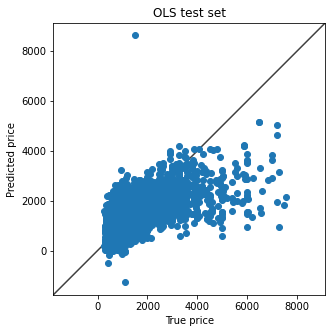

In [363]:
plot_pred_true_scatter(y, y_hat,title='OLS test set')

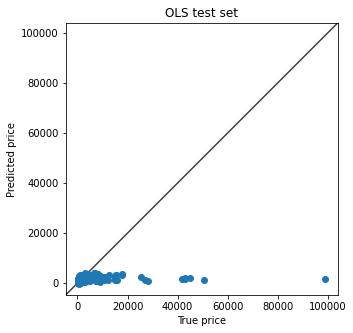

In [364]:
plot_pred_true_scatter(y_hold,y_hat_test,title='OLS test set')

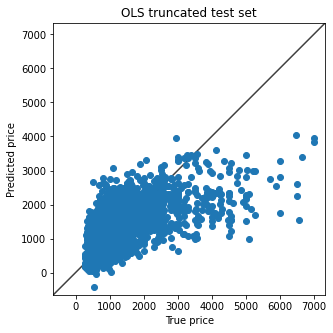

In [365]:
plot_pred_true_scatter(y_hold_t, y_hat_t,title='OLS truncated test set')

1.  LASSO

using extended model w interactions

In [67]:
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)

lasso_pipeline = Pipeline([("scale", StandardScaler()), ("regressor", lasso_model)])

lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(10, 50, 3)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)



y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_lasso), data_train)

lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 17 candidates, totalling 85 fits


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.556e+08, tolerance: 4.411e+05


[CV 1/5] END .....................alpha=0.01;, score=-802.628 total time=   1.8s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.379e+08, tolerance: 4.413e+05


[CV 2/5] END .....................alpha=0.01;, score=-753.114 total time=   1.9s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.577e+08, tolerance: 4.450e+05


[CV 3/5] END .....................alpha=0.01;, score=-832.323 total time=   1.7s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.374e+08, tolerance: 4.417e+05


[CV 4/5] END .....................alpha=0.01;, score=-799.860 total time=   1.9s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.043e+09, tolerance: 4.403e+05


[CV 5/5] END .....................alpha=0.01;, score=-790.561 total time=   1.4s
[CV 1/5] END .....................alpha=0.04;, score=-800.273 total time=   1.4s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e+06, tolerance: 4.413e+05


[CV 2/5] END .....................alpha=0.04;, score=-753.198 total time=   2.1s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.916e+08, tolerance: 4.450e+05


[CV 3/5] END .....................alpha=0.04;, score=-831.518 total time=   2.3s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e+07, tolerance: 4.417e+05


[CV 4/5] END .....................alpha=0.04;, score=-798.452 total time=   2.4s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.982e+06, tolerance: 4.403e+05


[CV 5/5] END .....................alpha=0.04;, score=-789.997 total time=   2.1s
[CV 1/5] END .....................alpha=0.07;, score=-798.667 total time=   1.4s
[CV 2/5] END .....................alpha=0.07;, score=-753.135 total time=   1.7s
[CV 3/5] END .....................alpha=0.07;, score=-830.838 total time=   1.8s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.974e+06, tolerance: 4.417e+05


[CV 4/5] END .....................alpha=0.07;, score=-796.889 total time=   2.1s
[CV 5/5] END .....................alpha=0.07;, score=-789.534 total time=   1.7s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.243e+07, tolerance: 4.411e+05


[CV 1/5] END ......................alpha=0.1;, score=-797.342 total time=   2.0s
[CV 2/5] END ......................alpha=0.1;, score=-753.077 total time=   1.7s
[CV 3/5] END ......................alpha=0.1;, score=-830.094 total time=   2.3s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.408e+07, tolerance: 4.417e+05


[CV 4/5] END ......................alpha=0.1;, score=-795.540 total time=   2.0s
[CV 5/5] END ......................alpha=0.1;, score=-789.157 total time=   1.6s
[CV 1/5] END .....................alpha=0.13;, score=-796.102 total time=   1.2s
[CV 2/5] END .....................alpha=0.13;, score=-753.065 total time=   0.9s
[CV 3/5] END .....................alpha=0.13;, score=-829.731 total time=   1.2s


/Users/vigadam/.local/share/virtualenvs/Assignment_2-7CJqppZW/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.027e+06, tolerance: 4.417e+05


[CV 4/5] END .....................alpha=0.13;, score=-794.305 total time=   1.7s
[CV 5/5] END .....................alpha=0.13;, score=-788.972 total time=   1.3s
[CV 1/5] END .....................alpha=0.16;, score=-795.124 total time=   1.4s
[CV 2/5] END .....................alpha=0.16;, score=-753.108 total time=   1.0s
[CV 3/5] END .....................alpha=0.16;, score=-829.454 total time=   0.9s
[CV 4/5] END .....................alpha=0.16;, score=-793.158 total time=   1.7s
[CV 5/5] END .....................alpha=0.16;, score=-788.717 total time=   1.1s
[CV 1/5] END .....................alpha=0.19;, score=-794.343 total time=   0.7s
[CV 2/5] END .....................alpha=0.19;, score=-753.222 total time=   1.5s
[CV 3/5] END .....................alpha=0.19;, score=-829.246 total time=   0.9s
[CV 4/5] END .....................alpha=0.19;, score=-792.175 total time=   1.8s
[CV 5/5] END .....................alpha=0.19;, score=-788.486 total time=   1.2s
[CV 1/5] END ...............

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.01, 0.04, 0.07, 0.1, 0.13, 0.16, 0.19,
                                   0.22, 0.25, 0.28, 0.31, 0.34, 0.37, 0.4,
                                   0.43, 0.46, 0.49]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [69]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

789.6106353933217

In [70]:
rfr = RangerForestRegressor(importance="impurity",seed = 42)

tune_grid = {"mtry": [8, 10, 12], "min_node_size": [5, 10, 15]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)

rf_model = rf_random.fit(X,y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........min_node_size=5, mtry=8;, score=-744.428 total time=   1.4s
[CV 2/5] END ........min_node_size=5, mtry=8;, score=-708.134 total time=   1.1s
[CV 3/5] END ........min_node_size=5, mtry=8;, score=-694.787 total time=   1.1s
[CV 4/5] END ........min_node_size=5, mtry=8;, score=-723.021 total time=   1.0s
[CV 5/5] END ........min_node_size=5, mtry=8;, score=-728.642 total time=   1.0s
[CV 1/5] END .......min_node_size=5, mtry=10;, score=-741.763 total time=   1.2s
[CV 2/5] END .......min_node_size=5, mtry=10;, score=-706.242 total time=   1.5s
[CV 3/5] END .......min_node_size=5, mtry=10;, score=-693.839 total time=   1.9s
[CV 4/5] END .......min_node_size=5, mtry=10;, score=-714.729 total time=   2.1s
[CV 5/5] END .......min_node_size=5, mtry=10;, score=-722.547 total time=   1.5s
[CV 1/5] END .......min_node_size=5, mtry=12;, score=-734.907 total time=   1.8s
[CV 2/5] END .......min_node_size=5, mtry=12;, sc

In [71]:
pd.DataFrame(rf_model.cv_results_)[
    ["param_mtry", "param_min_node_size", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_mtry"],
    Min_nodes=lambda x: x["param_min_node_size"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    4
)

Variables,8,10,12
Min_nodes,,,
5,719.8026,715.8238,711.6771
10,731.1236,721.1871,721.6035
15,736.6490,730.6568,728.3669


## XGBoost

In [139]:
xgb_cv = XGBRegressor(seed = 42)

tune_grid = {"max_depth": [6, 8, 10],"eta":[0.1,0.2,0.3]}

xrb_cv = GridSearchCV(
    xgb_cv,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)

xgb_model = xrb_cv.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...........eta=0.1, max_depth=6;, score=-712.029 total time=   3.9s
[CV 2/5] END ...........eta=0.1, max_depth=6;, score=-700.389 total time=   3.5s
[CV 3/5] END ...........eta=0.1, max_depth=6;, score=-667.757 total time=   2.5s
[CV 4/5] END ...........eta=0.1, max_depth=6;, score=-731.670 total time=   2.4s
[CV 5/5] END ...........eta=0.1, max_depth=6;, score=-714.525 total time=   4.2s
[CV 1/5] END ...........eta=0.1, max_depth=8;, score=-704.852 total time=   4.6s
[CV 2/5] END ...........eta=0.1, max_depth=8;, score=-682.499 total time=   3.4s
[CV 3/5] END ...........eta=0.1, max_depth=8;, score=-669.285 total time=   4.1s
[CV 4/5] END ...........eta=0.1, max_depth=8;, score=-724.884 total time=   4.2s
[CV 5/5] END ...........eta=0.1, max_depth=8;, score=-694.050 total time=   4.0s
[CV 1/5] END ..........eta=0.1, max_depth=10;, score=-731.489 total time=   6.5s
[CV 2/5] END ..........eta=0.1, max_depth=10;, sc

In [140]:
pd.DataFrame(xgb_model.cv_results_)[
    ["param_max_depth","param_eta", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Max_Depth=lambda x: x["param_max_depth"],
    Eta=lambda x: x["param_eta"],
).pivot(
    index="Max_Depth", columns="Eta", values="mean_test_score"
).round(
    4
)

Eta,0.1,0.2,0.3
Max_Depth,,,
6,705.2738,707.9643,716.6662
8,695.1139,702.8197,717.7379
10,704.1906,717.5899,714.2725


### Get best models from every model type

In [366]:
pd.DataFrame(
    {
        "RMSE": [
            ols_rmse,
            lasso_rmse,
            rf_model.cv_results_["mean_test_score"].max() *-1,
            xgb_model.cv_results_["mean_test_score"].max()*-1,
        ]
    },
    ["Reference OLS", "Lasso CV", "Random Forest CV", "XGBoost CV"],
).round(0)

,RMSE
Reference OLS,760.0
Lasso CV,790.0
Random Forest CV,712.0
XGBoost CV,695.0


Now, train the chosen model, on the whole train test!

In [143]:
final_model = Pipeline([("scale", StandardScaler()), ("regressor", xgb_model.best_estimator_)])

In [353]:
y, X = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_train)

xgb_final_fit = final_model.fit(X,y.ravel())


y_hat = xgb_final_fit.predict(X)

rf_rmse_train = mean_squared_error(y,y_hat,squared=False)
residual_std = np.std(y-y_hat)

print("Final model train rmse: "+str(rf_rmse_train))

y_hold, X_hold = dmatrices(target_variable + " ~ " + " + ".join(predictors_tree), data_holdout)

y_hat_test = xgb_final_fit.predict(X_hold)

rf_rmse_test = mean_squared_error(y_hold,y_hat_test,squared=False)
print("Final model test rmse: "+ str(rf_rmse_test))

Final model train rmse: 314.3647616087529
Final model test rmse: 3171.3532226536904


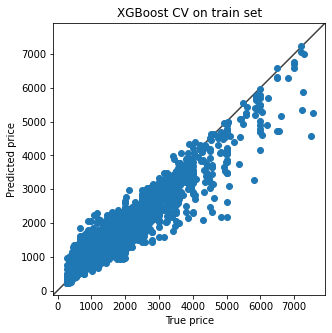

In [354]:
plot_pred_true_scatter(y,y_hat,title='XGBoost CV on train set')

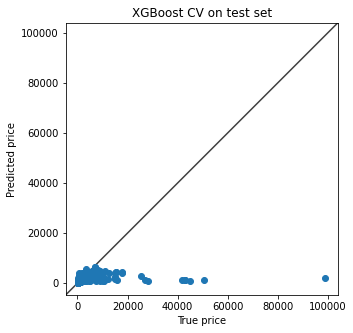

In [355]:
plot_pred_true_scatter(y_hold,y_hat_test,title='XGBoost CV on test set')

Final model truncated test rmse: 664.9904486908335


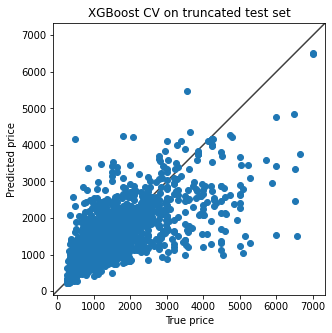

In [356]:
y_hold, X_hold = dmatrices(
    target_variable + " ~ " + " + ".join(predictors_tree),
    data_holdout.loc[lambda x: x["price"] < 7500],
)

y_hat_test = rf_final_fit.predict(X_hold)

rf_rmse_test = mean_squared_error(y_hold, y_hat_test, squared=False)
print("Final model truncated test rmse: " + str(rf_rmse_test))
plot_pred_true_scatter(
    y_hold, y_hat_test, title="XGBoost CV on truncated test set"
)

## PART III
### MODEL DIAGNOSTICS 
---

In [188]:
final_model_var_imp_df = (
    pd.DataFrame(final_model.steps[1][1].feature_importances_, X.design_info.column_names)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

**1) full varimp plot, above a cutoff**

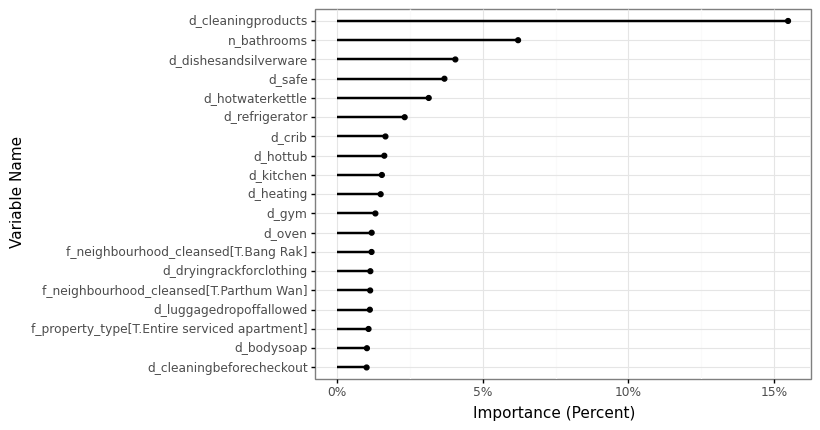

<ggplot: (304884164)>

In [189]:
ggplot(
    final_model_var_imp_df.loc[lambda x: x["imp_percentage"]>0.01],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**2) full varimp plot, top 10 only**

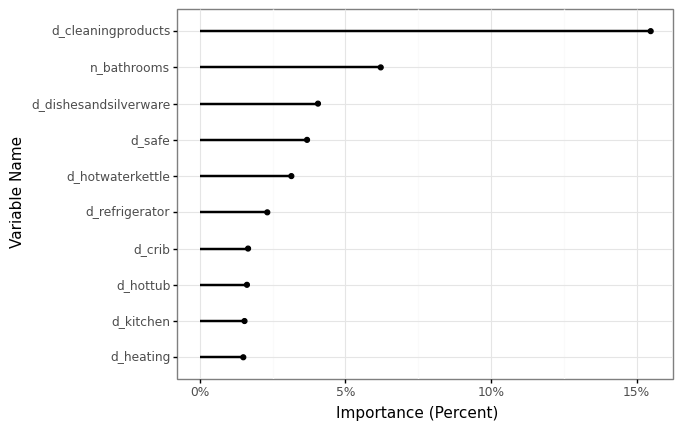

<ggplot: (305103945)>

In [190]:
ggplot(
    rf_model_2_var_imp_df.iloc[:10, :],
    aes(x="reorder(varname, imp)", y="imp_percentage"),
) + geom_point(size=1.5) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**3) grouped variable importance - keep binaries created off factors together**

For this, you need to create an sklearn pipeline and put OneHotEncoding in it (before, encoding was done by patsy's dmatrices). This way permutation_importance can calculate factor variables' importance 

In [200]:
categorical_columns = [col for col in predictors_tree if col.startswith("f_")]
numerical_columns = [col for col in predictors_tree if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

final_pipeline = Pipeline(
    [("preprocess", preprocessing), ("regressor", final_model)] # put best model to pipeline
)

final_pipeline.fit(data_train[predictors_tree],data_train[target_variable])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_bathrooms',
                                                   'n_accommodates',
                                                   'n_review_scores_rating',
                                                   'n_number_of_reviews',
                                                   'n_reviews_per_month',
                                                   'n_minimum_nights', 'n_beds',
                                                   'n_maximum_nights',
                                                   'n_days_since',
                    

In [201]:
# this takes a while to run
result = permutation_importance(
    final_pipeline,
    data_holdout[predictors_tree],
    data_holdout[target_variable],
    n_repeats=10,
    random_state=45,
)

In [202]:
categorical_columns

['f_property_type', 'f_neighbourhood_cleansed']

In [203]:
grouped_imp = (
    pd.DataFrame(
        result.importances_mean,
        data_train[predictors_tree].columns,
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
    .head(10)
)

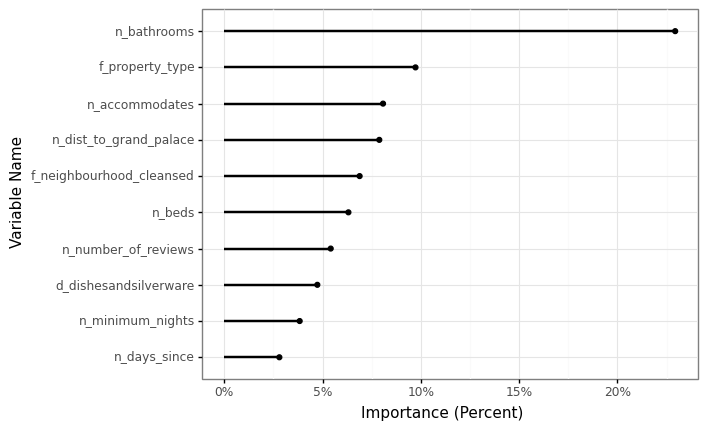

<ggplot: (304726968)>

In [204]:
ggplot(grouped_imp, aes(x="reorder(varname, imp)", y="imp_percentage"),) + geom_point( size=1.5
) + geom_segment(
    aes(x="varname", xend="varname", y=0, yend="imp_percentage"), size=1
) + ylab(
    "Importance (Percent)"
) + xlab(
    "Variable Name"
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

## Partial Dependence Plots 
-------------------------------------------------------


In [262]:
bath_pdp = partial_dependence(
    final_pipeline,
    data_holdout[predictors_tree].assign(
        n_bathrooms=lambda x: x["n_bathrooms"].astype(int)
    ),
    ["n_bathrooms"],
    kind="average",
)

bath_pdp = (
    pd.DataFrame(bath_pdp["average"], columns=bath_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Bathrooms"}, axis=1)
)


n_bootstrap = 50

bathrooms = bath_pdp["Bathrooms"].tolist()
expected_value_bootstrap_replications = []
for _ in range(n_bootstrap):
    X_boot, y_boot = resample(
        data_holdout[predictors_tree].assign(
            n_bathrooms=lambda x: x["n_bathrooms"].astype(int)
        ),
        data_holdout[target_variable],
    )

    final_booted = final_pipeline.fit(X_boot, y_boot)

    expected_value_bootstrap_replications.append(
        partial_dependence(final_booted, X_boot, ["n_bathrooms"], kind="average")[
            "average"
        ][0]
    )

bath_pdp["prediction_se"] = (
    pd.DataFrame(expected_value_bootstrap_replications).dropna().std(axis=0).tolist()
)

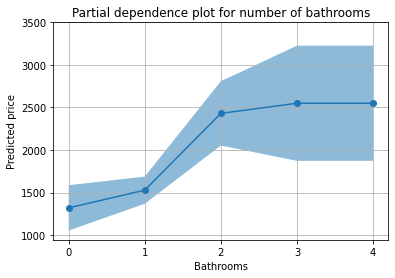

In [320]:
plt.plot(bathrooms, bath_pdp["Predicted price"],marker="o")
plt.fill_between(
    bathrooms,
    bath_pdp["Predicted price"] - 1.96 * bath_pdp["prediction_se"],
    bath_pdp["Predicted price"] + 1.96 * bath_pdp["prediction_se"],
    alpha=0.5,
    label="Bootstrap 95%CI",
)
plt.ylabel("Predicted price")
plt.xlabel("Bathrooms")
plt.title("Partial dependence plot for number of bathrooms")
plt.grid()
plt.xticks(bathrooms)
plt.yticks([i*500 for i in range(2,8)])
plt.show()

In [233]:
accom_pdp = partial_dependence(
    final_pipeline, data_holdout[predictors_tree], ["n_accommodates"], kind="average"
)

accom_pdp = (
    pd.DataFrame(accom_pdp["average"], columns=accom_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Accomodates (person)"}, axis=1)
)


n_bootstrap = 50

accomodates = accom_pdp["Accomodates (person)"].tolist()
expected_value_bootstrap_replications = []
for _ in range(n_bootstrap):
    X_boot, y_boot = resample(
        data_holdout[predictors_tree], data_holdout[target_variable]
    )

    final_booted = final_pipeline.fit(X_boot, y_boot)

    expected_value_bootstrap_replications.append(
        partial_dependence(final_booted, X_boot, ["n_accommodates"], kind="average")[
            "average"
        ][0]
    )


accom_pdp["prediction_se"] = np.std(expected_value_bootstrap_replications, axis=0)[0]

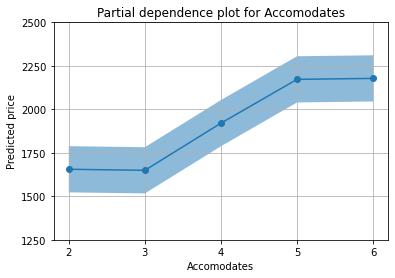

In [318]:
plt.plot(accomodates, accom_pdp["Predicted price"],marker="o")
plt.fill_between(
    accomodates,
    accom_pdp["Predicted price"] - 1.96 * accom_pdp["prediction_se"],
    accom_pdp["Predicted price"] + 1.96 * accom_pdp["prediction_se"],
    alpha=0.5,
    label="Bootstrap 95%CI",
)
plt.ylabel("Predicted price")
plt.xlabel("Accomodates")
plt.title("Partial dependence plot for Accomodates")
plt.grid()
plt.xticks(accomodates)
plt.yticks([i*250 for i in range(5,11)])
plt.show()

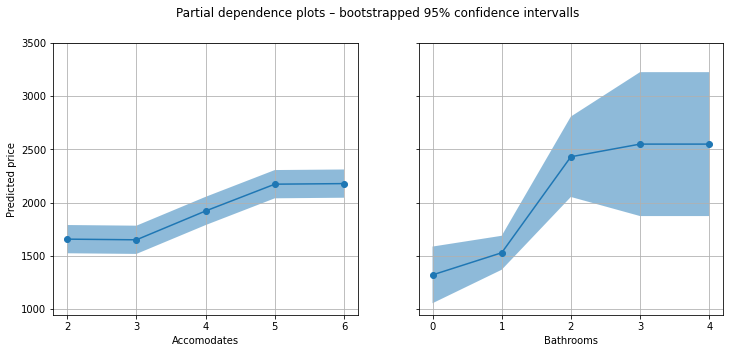

In [344]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(12,5))
fig.suptitle('Partial dependence plots – bootstrapped 95% confidence intervalls')

ax1.plot(accomodates, accom_pdp["Predicted price"], marker="o")
ax1.fill_between(
    accomodates,
    accom_pdp["Predicted price"] - 1.96 * accom_pdp["prediction_se"],
    accom_pdp["Predicted price"] + 1.96 * accom_pdp["prediction_se"],
    alpha=0.5,
    label="Bootstrap 95%CI",
)
ax1.set_ylabel("Predicted price")
ax1.set_xlabel("Accomodates")
ax1.grid()
ax1.set_xticks(accomodates)
ax1.set_yticks([i*500 for i in range(2,8)])



ax2.plot(bathrooms, bath_pdp["Predicted price"], marker="o")

ax2.fill_between(
    bathrooms,
    bath_pdp["Predicted price"] - 1.96 * bath_pdp["prediction_se"],
    bath_pdp["Predicted price"] + 1.96 * bath_pdp["prediction_se"],
    alpha=0.5,
    label="Bootstrap 95%CI",
)
ax2.set_xlabel("Bathrooms")
ax2.grid()
ax2.set_xticks(bathrooms)
ax2.set_yticks([i*500 for i in range(2,8)])

plt.savefig("../figures/PDP_plot.png")
plt.show()


### Subsample performance: RMSE / mean(y) 
---------------------------------------
NOTE  we do this on the holdout set.


In [211]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=final_pipeline.predict(data_holdout[predictors_tree])
)

create nice summary table of heterogeneity

In [212]:
from sklearn.metrics import mean_squared_error


def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [213]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "Size <= 3", "Size > 3")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [227]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)

In [214]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        data.f_neighbourhood_cleansed.value_counts().head(10).index.tolist()
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

In [215]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
all_holdout.index = ["All"]

In [228]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Property type","Borough"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")

In [347]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset.sort_values(by="rmse_norm"),
        type_rows.iloc[[1]],
        proptype_subset.sort_values(by=["rmse_norm"]),
        type_rows.iloc[[2]],
        neightbourhood_subset.sort_values(by="rmse_norm"),
        all_holdout.round(2),
    ]
).rename(columns={"rmse":"RMSE","mean_price":"Mean price","rmse_norm":"Norm. RMSE"})

,RMSE,Mean price,Norm. RMSE
Apartment size,,,
Size > 3,3357.9,2244.25,1.5
Size <= 3,3085.59,1402.38,2.2
Property type,,,
Entire serviced apartment,3152.2,3134.88,1.01
Entire rental unit,2612.12,1577.97,1.66
Entire condominium (condo),3736.67,1584.53,2.36
Borough,,,
Vadhana,862.55,1730.12,0.5
Khlong Toei,864.48,1326.54,0.65
